In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import albumentations as A

In [2]:
file_path = 'C:/Users/USER/Desktop/open'

train_df = pd.read_csv('C:/Users/USER/Desktop/open/train.csv')
test_df = pd.read_csv('C:/Users/USER/Desktop/open/test.csv')

print(train_df.head())
print(test_df.head())

                  img_path                 upscale_img_path              label
0  ./train/TRAIN_00000.jpg  ./upscale_train/TRAIN_00000.png     Ruddy Shelduck
1  ./train/TRAIN_00001.jpg  ./upscale_train/TRAIN_00001.png       Gray Wagtail
2  ./train/TRAIN_00002.jpg  ./upscale_train/TRAIN_00002.png     Indian Peacock
3  ./train/TRAIN_00003.jpg  ./upscale_train/TRAIN_00003.png  Common Kingfisher
4  ./train/TRAIN_00004.jpg  ./upscale_train/TRAIN_00004.png  Common Kingfisher
           id               img_path
0  TEST_00000  ./test/TEST_00000.jpg
1  TEST_00001  ./test/TEST_00001.jpg
2  TEST_00002  ./test/TEST_00002.jpg
3  TEST_00003  ./test/TEST_00003.jpg
4  TEST_00004  ./test/TEST_00004.jpg


In [3]:
train_df['label'].value_counts()

label
Ruddy Shelduck               671
White-Breasted Kingfisher    666
Red-Wattled Lapwing          663
Northern Lapwing             663
Gray Wagtail                 661
White Wagtail                659
Jungle Babbler               658
Sarus Crane                  657
Common Kingfisher            657
Common Rosefinch             653
White-Breasted Waterhen      649
Indian Grey Hornbill         645
Common Tailorbird            643
Brown-Headed Barbet          642
Cattle Egret                 641
Indian Roller                639
Indian Peacock               637
Hoopoe                       631
House Crow                   630
Common Myna                  630
Forest Wagtail               629
Rufous Treepie               616
Asian Green Bee-Eater        613
Coppersmith Barbet           550
Indian Pitta                 431
Name: count, dtype: int64

In [4]:
unique_labels_count = len(train_df['label'].unique())
print("Label 종류 개수:", unique_labels_count)

Label 종류 개수: 25


In [5]:
from sklearn.preprocessing import LabelEncoder

label_encode = LabelEncoder()
train_df['label'] = label_encode.fit_transform(train_df['label'])

train_df['label'].unique()

array([19,  9, 13,  3,  5, 16,  6, 24, 21,  4,  8, 15, 17, 12, 10, 14, 18,
        2, 23, 20, 22, 11,  7,  1,  0])

In [6]:
transform = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    A.HorizontalFlip(p=0.3)
])

In [7]:
from PIL import Image
import cv2

train_images = []
train_labels = []
test_images = []

for file in train_df['img_path']:
    image = cv2.imread(file_path + file)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    augmented_image = np.array(transform(image = image_rgb)['image'])
    train_images.append(augmented_image)
    
for label in train_df['label']:
    train_labels.append(label)
    
for file in test_df['img_path']:
    image = np.array(Image.open(file_path + file))
    test_images.append(image)
    
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)

In [ ]:
train_images.shape, train_labels.shape

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels ,test_size = 0.3, 
                                                    stratify = train_df['label'], random_state = 123)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11083, 224, 224, 3), (4751, 224, 224, 3), (11083,), (4751,))

In [10]:
y_train_onehot = pd.get_dummies(y_train).values
y_test_onehot = pd.get_dummies(y_test).values

y_train_onehot.shape, y_test_onehot.shape

((11083, 25), (4751, 25))

In [11]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Input
from keras.layers import Dense, Flatten, Dropout

In [12]:
input_layer = Input(shape=(224, 224, 3))

conv1 = Conv2D(filters = 32, kernel_size = 3, activation = 'relu', padding = 'same')(input_layer)
maxpooling1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same')(maxpooling1)
maxpooling2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same')(maxpooling2)
maxpooling3 = MaxPooling2D((2, 2))(conv3)
flatten = Flatten()(maxpooling3)
dense = Dense(32, activation = 'relu')(flatten)
outputs = Dense(25, activation = 'softmax')(dense)

model = keras.Model(input_layer, outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        369

In [13]:
import gc
gc.collect()

63

In [14]:
history = model.fit(X_train, y_train_onehot, batch_size = 8, epochs = 30, validation_data = (X_test, y_test_onehot))

Epoch 1/30


1386/1386 [==============================] - 444s 318ms/step - loss: 3.1746 - accuracy: 0.0584 - val_loss: 3.0873 - val_accuracy: 0.0901
Epoch 2/30
1386/1386 [==============================] - 459s 331ms/step - loss: 3.0121 - accuracy: 0.1034 - val_loss: 2.9468 - val_accuracy: 0.1244
Epoch 3/30
1386/1386 [==============================] - 490s 354ms/step - loss: 2.8078 - accuracy: 0.1722 - val_loss: 2.7215 - val_accuracy: 0.1869
Epoch 4/30
1386/1386 [==============================] - 474s 342ms/step - loss: 2.5107 - accuracy: 0.2570 - val_loss: 2.6565 - val_accuracy: 0.2206
Epoch 5/30
1386/1386 [==============================] - 498s 359ms/step - loss: 2.2269 - accuracy: 0.3330 - val_loss: 2.7825 - val_accuracy: 0.2254
Epoch 6/30
1386/1386 [==============================] - 511s 369ms/step - loss: 1.9590 - accuracy: 0.4021 - val_loss: 2.8758 - val_accuracy: 0.2330
Epoch 7/30
  28/1386 [..............................] - ETA: 9:52 - loss: 1.6911 - accuracy: 0.4777

KeyboardInterrupt: 

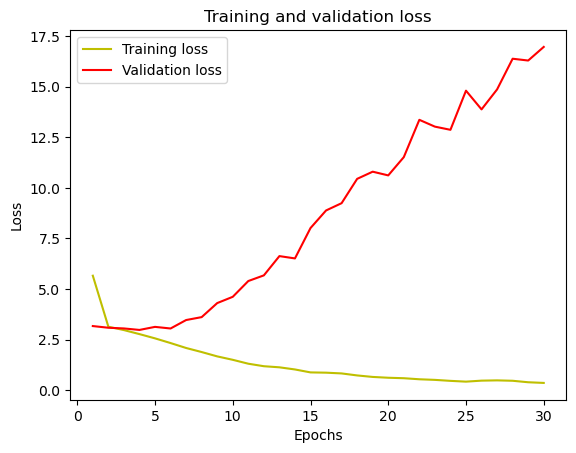

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

loss =history.history['loss']
val_loss =history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

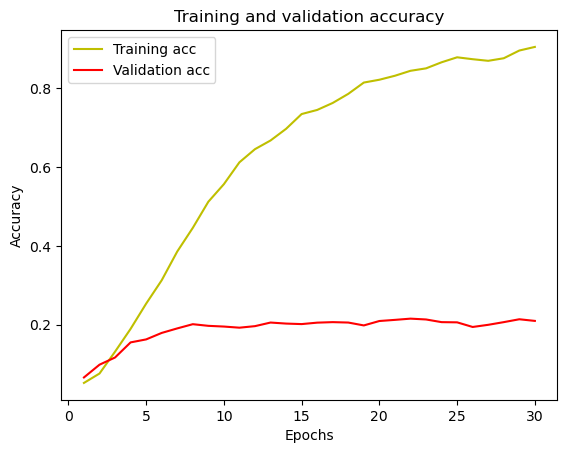

In [16]:
acc =history.history['accuracy']
val_acc =history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
model.save(r'C:/Users/USER/Desktop/bird_model')

INFO:tensorflow:Assets written to: C:/Users/USER/Desktop/bird_model\assets


INFO:tensorflow:Assets written to: C:/Users/USER/Desktop/bird_model\assets


In [26]:
from sklearn.metrics import classification_report,confusion_matrix


y_pred = model.predict(X_test)
y_test_class = np.argmax(y_test_onehot,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

120/120 [==============================] - 5s 43ms/step


In [24]:
classes = ['Ruddy Shelduck', 'White-Breasted Kingfisher', 'Red-Wattled Lapwing'
          , 'Northern Lapwing', 'Gray Wagtail', 'White Wagtail', 'Jungle Babbler'
          , 'Sarus Crane', 'Common Kingfisher', 'Common Rosefinch'
          , 'White-Breasted Waterhen', 'Indian Grey Hornbill'
          , 'Common Tailorbird', 'Brown-Headed Barbet', 'Cattle Egret'
          , 'Indian Roller', 'Indian Peacock', 'Hoopoe', 'House Crow'
          , 'Common Myna', 'Forest Wagtail', 'Rufous Treepie'
          , 'Asian Green Bee-Eater', 'Coppersmith Barbet'
          , 'Indian Pitta']

In [27]:
#Accuracy of the predicted values
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.12      0.14      0.13       151
           1       0.08      0.10      0.09       135
           2       0.35      0.30      0.32       168
           3       0.31      0.26      0.28       173
           4       0.22      0.25      0.23       160
           5       0.13      0.13      0.13       163
           6       0.15      0.16      0.15       145
           7       0.11      0.12      0.11       136
           8       0.22      0.26      0.24       152
           9       0.13      0.10      0.11       177
          10       0.39      0.42      0.40       161
          11       0.22      0.24      0.23       144
          12       0.18      0.16      0.17       154
          13       0.36      0.27      0.31       162
          14       0.08      0.06      0.07        95
          15       0.18      0.17      0.18       149
          16       0.13      0.10      0.11       146
          17       0.26    